In [1]:
import torch

from reggae.data_loaders.datasets import P53Data
from reggae.gp.variational import SingleLinearLFM, TranscriptionalTrainer
from reggae.utilities import save, load
from reggae.plot.variational_plotters import Plotter

from matplotlib import pyplot as plt
import numpy as np

f64 = np.float64


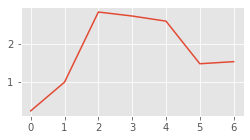

In [2]:
dataset = P53Data()

num_genes = len(dataset)

num_tfs = 1

t_inducing = torch.linspace(0, 1, 4, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(0, 1, 7).view(-1)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes)
])

plt.figure(figsize=(4, 2))
plt.plot(dataset[0][1])

In [3]:
#ExponentialLFM
model = SingleLinearLFM(num_genes, num_tfs,
                        t_inducing, dataset, extra_points=2,
                        fixed_variance=dataset.variance, learn_inducing=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
trainer = TranscriptionalTrainer(model, optimizer, dataset, batch_size=5)

C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models\model.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=learn_inducing)


### Outputs prior to training:

C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:103: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


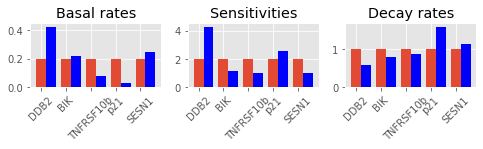

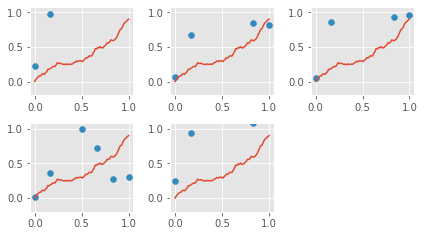

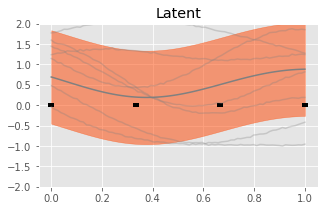

In [4]:
plotter = Plotter(model, dataset.gene_names)

t_predict = torch.linspace(f64(0), f64(1), 80, dtype=torch.float64)

rtol = 1e-3
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol,
    'num_samples': 1
}

plotter.plot_kinetics()
plotter.plot_outputs(t_predict, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict)

Epoch 1/100 - Loss: 289.79 (289.79 0.00) λ: 0.183 b: 0.30 d 0.90 s: 2.10
Epoch 6/100 - Loss: 244.69 (243.63 1.06) λ: 0.179 b: 0.78 d 0.49 s: 2.55
Epoch 11/100 - Loss: 206.55 (201.59 4.96) λ: 0.217 b: 1.01 d 0.71 s: 2.60
Epoch 16/100 - Loss: 184.04 (177.54 6.51) λ: 0.176 b: 1.08 d 1.01 s: 2.55
Epoch 21/100 - Loss: 130.43 (123.71 6.71) λ: 0.141 b: 1.15 d 1.23 s: 2.64
Epoch 26/100 - Loss: 83.24 (76.06 7.19) λ: 0.135 b: 1.30 d 1.28 s: 2.86
Epoch 31/100 - Loss: 81.40 (75.06 6.35) λ: 0.114 b: 1.39 d 1.34 s: 3.05
Epoch 36/100 - Loss: 93.10 (87.09 6.01) λ: 0.094 b: 1.42 d 1.43 s: 3.10
Epoch 41/100 - Loss: 60.61 (54.73 5.87) λ: 0.083 b: 1.56 d 1.36 s: 3.18
Epoch 46/100 - Loss: 83.77 (78.08 5.68) λ: 0.080 b: 1.70 d 1.28 s: 3.22
Epoch 51/100 - Loss: 192.89 (187.26 5.63) λ: 0.085 b: 1.74 d 1.30 s: 3.22
Epoch 56/100 - Loss: 77.61 (70.20 7.41) λ: 0.095 b: 1.71 d 1.42 s: 3.09
Epoch 61/100 - Loss: 84.54 (74.74 9.80) λ: 0.103 b: 1.70 d 1.49 s: 2.99
Epoch 66/100 - Loss: 56.88 (47.64 9.24) λ: 0.101 b: 1.

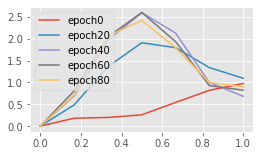

In [5]:
tol = 1e-2
import time
start = time.time()

output = trainer.train(100, rtol=tol, atol=tol/10,
                       report_interval=5, plot_interval=20, num_samples=3)
end = time.time()
print(end - start)

### Outputs after training

C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:103: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


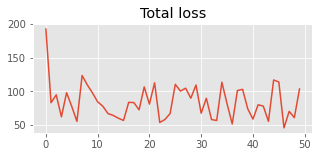

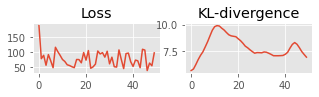

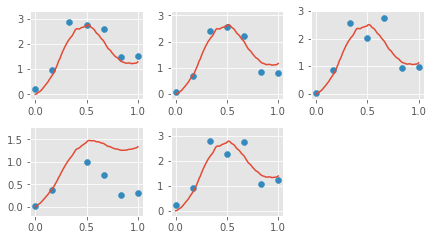

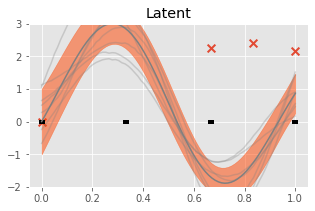

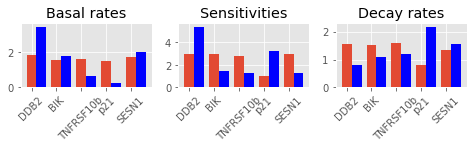

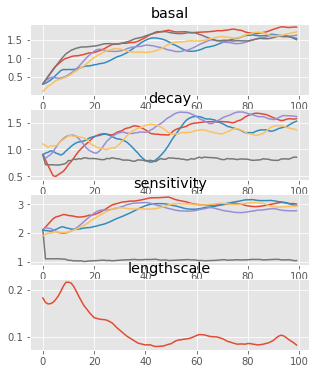

In [9]:

plotter.plot_losses(trainer)
plotter.plot_outputs(t_predict, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 3), plot_barenco=True, plot_inducing=False)
plotter.plot_kinetics()
plotter.plot_convergence(trainer)

In [7]:
save(model, 'variational_linear')

In [8]:
do_load = False
if do_load:
    model = load('variational_linear', SingleLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = TranscriptionalTrainer(model, optimizer, dataset, batch_size=5)
print(do_load)

False
